# Benchmark Performance For Log Loss = Binary Cross Entropy
## Numpy vs different Cython implementations
With $\eta = \mathrm{raw\_prediction}$ and $\mathrm{y_{pred}} = expit(\eta) = \frac{exp(\eta)}{1 + exp(\eta)}$ we have
$$log\_loss =  log(1 + exp(\eta)) - y_{true} \eta$$

In [1]:
%load_ext cython

In [2]:
import numpy as np
from scipy.special import expit


# numpy ufunc version
# Note: log1p(exp(x)) is faster than logaddexp(x)
def np_logloss(y_true, raw):
    # logaddexp(0, x) = log(1 + exp(x))
    # return np.logaddexp(0, raw) - y_true * raw
    #
    # numerically stable, but slower
    # pos = raw > 0
    # out = - y_true * raw
    # out[pos] += raw[pos] + np.log1p(np.exp(-raw[pos]))
    # out[~pos] += np.log1p(np.exp(-raw[~pos]))
    # return out
    #
    # return np.where(raw >= 0, raw + np.log1p(np.exp(-raw)) - y_true * raw, np.log1p(np.exp(raw)) - y_true * raw)
    #
    # fast, but unstable for raw > 700
    return np.log1p(np.exp(raw)) - y_true * raw
    

def np_gradient(y_true, raw):
    return expit(raw) - y_true

In [3]:
%%cython -3
# cython: boundscheck=False
# cython: wraparound=False

import cython
from cython.parallel import prange
import numpy as np

from libc.math cimport exp, log, log1p
cimport numpy as np
from scipy.special.cython_special cimport expit

np.import_array()


cdef double c_logloss(double y_true, double raw) nogil:
    if raw <= 0:
        return log1p(exp(raw)) - y_true * raw
    else:
        # log(1 + exp(x)) = x + log(1 + exp(-x))
        return raw + log1p(exp(-raw)) - y_true * raw


def p_logloss(double[::1] y_true, double[::1] raw):
    cdef:
        int n_samples
        int i
        cdef double[::1] out = np.empty_like(y_true)
    
    n_samples = y_true.shape[0]
    for i in range(n_samples):
        out[i] = c_logloss(y_true[i], raw[i])
        
    return out


cdef double c_gradient(double y_true, double raw) nogil:
        return expit(raw) - y_true


def p_gradient(double[::1] y_true, double[::1] raw):
    cdef:
        int n_samples
        int i
        cdef double[::1] out = np.empty_like(y_true)
    
    n_samples = y_true.shape[0]
    for i in range(n_samples):
        out[i] = c_gradient(y_true[i], raw[i])
        
    return out


cdef class Logloss():
    
    @staticmethod
    cdef double static_logloss(double y_true, double raw) nogil:
        if raw <= 0:
            return log1p(exp(raw)) - y_true * raw
        else:
            # log(1 + exp(x)) = x + log(1 + exp(-x))
            return raw + log1p(exp(-raw)) - y_true * raw
    
    @staticmethod
    cdef double static_gradient(double y_true, double raw) nogil:
            return expit(raw) - y_true

    def loss(self, double[::1] y_true, double[::1] raw):
        cdef:
            int n_samples
            int i
            cdef double[::1] out = np.empty_like(y_true)
        
        n_samples = y_true.shape[0]
        for i in range(n_samples):
            out[i] = Logloss.static_logloss(y_true[i], raw[i])
            
        return np.asarray(out)
    
    def gradient(self, double[::1] y_true, double[::1] raw):
        cdef:
            int n_samples
            int i
            cdef double[::1] out = np.empty_like(y_true)
        
        n_samples = y_true.shape[0]
        for i in range(n_samples):
            out[i] = Logloss.static_gradient(y_true[i], raw[i])
            
        return np.asarray(out)
            

cdef class BaseLoss():

    cdef double _loss(self, double y_true, double raw) nogil:
        return 1.
    
    cdef double _gradient(self, double y_true, double raw) nogil:
        return 1.

    def loss(self, double[::1] y_true, double[::1] raw):
        cdef:
            int n_samples
            int i
            cdef double[::1] out = np.empty_like(y_true)

        n_samples = y_true.shape[0]
        for i in range(n_samples):
            out[i] = self._loss(y_true[i], raw[i])
            
        return np.asarray(out)
    
    def gradient(self, double[::1] y_true, double[::1] raw):
        cdef:
            int n_samples
            int i
            cdef double[::1] out = np.empty_like(y_true)

        n_samples = y_true.shape[0]
        for i in range(n_samples):
            out[i] = self._gradient(y_true[i], raw[i])
            
        return np.asarray(out)


cdef class Logloss_virtual(BaseLoss):

    cdef double _loss(self, double y_true, double raw) nogil:
        if raw <= 0:
            return log1p(exp(raw)) - y_true * raw
        else:
            # log(1 + exp(x)) = x + log(1 + exp(-x))
            return raw + log1p(exp(-raw)) - y_true * raw
        
    cdef double _gradient(self, double y_true, double raw) nogil:
        return expit(raw) - y_true

### Simple Timings

In [4]:
rng = np.random.default_rng(0)
y_true = rng.standard_normal(100_000, dtype=np.float64)
raw = rng.standard_normal(100_000, dtype=np.float64)

In [5]:
[np.sum(np_logloss(y_true, raw) - p_logloss(y_true, raw)),
 np.sum(np_logloss(y_true, raw) - Logloss().loss(y_true, raw)),
 np.sum(np_logloss(y_true, raw) - Logloss_virtual().loss(y_true, raw))
]

[1.27675647831893e-14, 1.27675647831893e-14, 1.27675647831893e-14]

In [6]:
%%timeit -r10 -n100
np_logloss(y_true, raw)

1.49 ms ± 47.2 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [7]:
%%timeit -r10 -n100
p_logloss(y_true, raw)

3.07 ms ± 641 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [8]:
%%timeit -r10 -n100
Logloss().loss(y_true, raw)

3.02 ms ± 429 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [9]:
%%timeit -r10 -n100
Logloss_virtual().loss(y_true, raw)

3.12 ms ± 176 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [10]:
[np.sum(np_gradient(y_true, raw) - p_gradient(y_true, raw)),
 np.sum(np_gradient(y_true, raw) - Logloss().gradient(y_true, raw)),
 np.sum(np_gradient(y_true, raw) - Logloss_virtual().gradient(y_true, raw))
]

[0.0, 0.0, 0.0]

In [11]:
%%timeit -r10 -n500
np_gradient(y_true, raw)

882 µs ± 206 µs per loop (mean ± std. dev. of 10 runs, 500 loops each)


In [12]:
%%timeit -r10 -n500
p_gradient(y_true, raw)

760 µs ± 47.9 µs per loop (mean ± std. dev. of 10 runs, 500 loops each)


In [13]:
%%timeit -r10 -n500
Logloss().gradient(y_true, raw)

844 µs ± 107 µs per loop (mean ± std. dev. of 10 runs, 500 loops each)


In [14]:
%%timeit -r10 -n500
Logloss_virtual().gradient(y_true, raw)

963 µs ± 104 µs per loop (mean ± std. dev. of 10 runs, 500 loops each)


### Benchmark Loss

In [15]:
from collections import OrderedDict
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from neurtu import delayed, timeit, Benchmark


# See https://github.com/mwaskom/seaborn/issues/1986
#g = sns.FacetGrid(df.wall_time.reset_index(), hue="function", height =5)
#g.map(plt.errorbar, "N", "mean", yerr=df.wall_time.reset_index()['std']);

# This works
# See https://stackoverflow.com/a/30428808
def errplot(x, y, yerr, **kwargs):
    ax = plt.gca()
    data = kwargs.pop("data")
    data.plot(x=x, y=y, yerr=yerr, kind="line", ax=ax, **kwargs)

In [16]:
n_samples = 1000_000
rng = np.random.default_rng(42)
y_pred = rng.standard_normal(n_samples)
raw = rng.standard_normal(n_samples)

func_list = [(np_logloss, "np_logloss"),
             (p_logloss, "p_logloss"),
             (Logloss().loss, "Logloss().loss"),
             (Logloss_virtual().loss, "Logloss_virtual().loss")
            ]

def benchmark_cases():
    for N in np.logspace(np.log10(10), np.log10(n_samples), 10).astype('int'):
        for func, name in func_list:
            tags = OrderedDict(N=N, function=name)
            yield delayed(func, tags=tags)(y_pred[:N], raw[:N])

In [17]:
%%time
bench = Benchmark(wall_time=True, peak_memory=True, repeat=20)
df = bench(benchmark_cases())

CPU times: user 7min 15s, sys: 28.9 s, total: 7min 44s
Wall time: 8min 3s


In [18]:
df.head()

wall_time                         peak_memory  \
                               mean       max           std        mean   
N  function                                                               
10 Logloss().loss          0.000007  0.000011  9.903070e-07    0.000000   
   Logloss_virtual().loss  0.000007  0.000013  1.672612e-06    0.000000   
   np_logloss              0.000004  0.000006  9.361720e-07    0.000195   
   p_logloss               0.000007  0.000028  4.940860e-06    0.000000   
35 Logloss().loss          0.000007  0.000010  7.729920e-07    0.000000   

                                               
                                max       std  
N  function                                    
10 Logloss().loss          0.000000  0.000000  
   Logloss_virtual().loss  0.000000  0.000000  
   np_logloss              0.003906  0.000873  
   p_logloss               0.000000  0.000000  
35 Logloss().loss          0.000000  0.000000

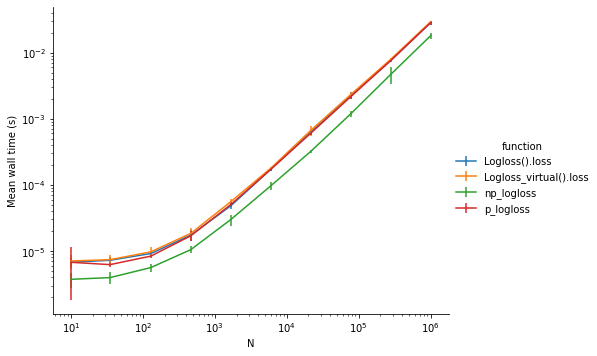

In [19]:
g = sns.FacetGrid(df.wall_time.reset_index(), hue="function", height=5, aspect=4/3)
g.map_dataframe(errplot, "N", "mean", "std")
g.set(xscale="log", yscale="log")
g.set_axis_labels(y_var="Mean wall time (s)")
g.add_legend()

Text(0.5, 1.0, 'Ratio of wall time compared to np_logloss')

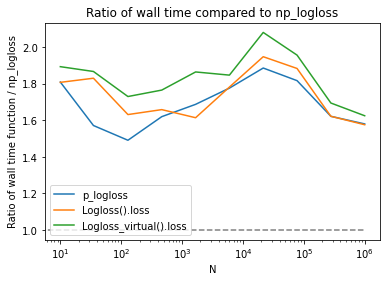

In [20]:
df_plot = pd.DataFrame(index=df.index.get_level_values(0))
df_plot['p_logloss'] = df.wall_time.unstack(-1).loc[:, ('mean', 'p_logloss')] / df.wall_time.unstack(-1).loc[:, ('mean', 'np_logloss')]
df_plot['Logloss().loss'] = df.wall_time.unstack(-1).loc[:, ('mean', 'Logloss().loss')] / df.wall_time.unstack(-1).loc[:, ('mean', 'np_logloss')]
df_plot['Logloss_virtual().loss'] = df.wall_time.unstack(-1).loc[:, ('mean', 'Logloss_virtual().loss')] / df.wall_time.unstack(-1).loc[:, ('mean', 'np_logloss')]

df_plot.plot()
plt.hlines(1, 0, 1e6, color='grey', linestyles='dashed')
plt.xscale("log")
#plt.yscale("log")
plt.ylabel("Ratio of wall time function / np_logloss")
plt.title("Ratio of wall time compared to np_logloss")

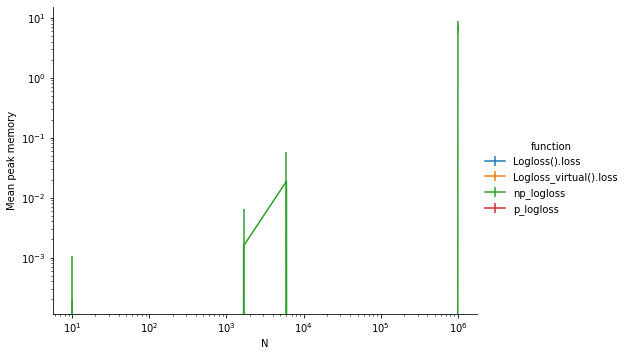

In [21]:
g = sns.FacetGrid(df.peak_memory.reset_index(), hue="function", height=5, aspect=4/3)
g.map_dataframe(errplot, "N", "mean", "std")
g.set(xscale="log", yscale="log")
g.set_axis_labels(y_var="Mean peak memory")
g.add_legend()

### Benchmark Gradient

In [22]:
n_samples = 1000_000
rng = np.random.default_rng(42)
y_pred = rng.standard_normal(n_samples)
raw = rng.standard_normal(n_samples)

func_list = [(np_gradient, "np_gradient"),
             (p_gradient, "p_gradient"),
             (Logloss().gradient, "Logloss().gradient"),
             (Logloss_virtual().gradient, "Logloss_virtual().gradient")
            ]

def benchmark_cases():
    for N in np.logspace(np.log10(10), np.log10(n_samples), 10).astype('int'):
        for func, name in func_list:
            tags = OrderedDict(N=N, function=name)
            yield delayed(func, tags=tags)(y_pred[:N], raw[:N])

In [23]:
%%time
bench = Benchmark(wall_time=True, peak_memory=True, repeat=20)
df = bench(benchmark_cases())

CPU times: user 6min 57s, sys: 37.8 s, total: 7min 35s
Wall time: 8min 8s


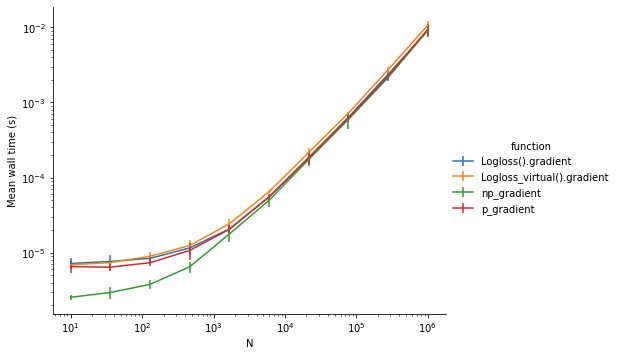

In [24]:
g = sns.FacetGrid(df.wall_time.reset_index(), hue="function", height=5, aspect=4/3)
g.map_dataframe(errplot, "N", "mean", "std")
g.set(xscale="log", yscale="log")
g.set_axis_labels(y_var="Mean wall time (s)")
g.add_legend()

Text(0.5, 1.0, 'Ratio of wall time compared to np_gradient')

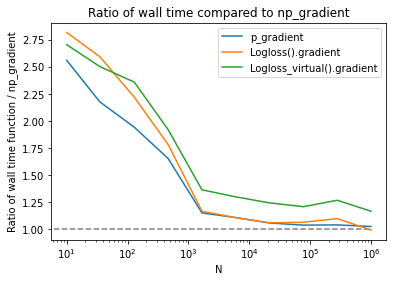

In [25]:
df_plot = pd.DataFrame(index=df.index.get_level_values(0))
df_plot['p_gradient'] = df.wall_time.unstack(-1).loc[:, ('mean', 'p_gradient')] / df.wall_time.unstack(-1).loc[:, ('mean', 'np_gradient')]
df_plot['Logloss().gradient'] = df.wall_time.unstack(-1).loc[:, ('mean', 'Logloss().gradient')] / df.wall_time.unstack(-1).loc[:, ('mean', 'np_gradient')]
df_plot['Logloss_virtual().gradient'] = df.wall_time.unstack(-1).loc[:, ('mean', 'Logloss_virtual().gradient')] / df.wall_time.unstack(-1).loc[:, ('mean', 'np_gradient')]

df_plot.plot()
plt.hlines(1, 0, 1e6, color='grey', linestyles='dashed')
plt.xscale("log")
#plt.yscale("log")
plt.ylabel("Ratio of wall time function / np_gradient")
plt.title("Ratio of wall time compared to np_gradient")

/Users/lorentzen/github/python3_general/lib/python3.7/site-packages/seaborn/axisgrid.py:49: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set(**kwargs)


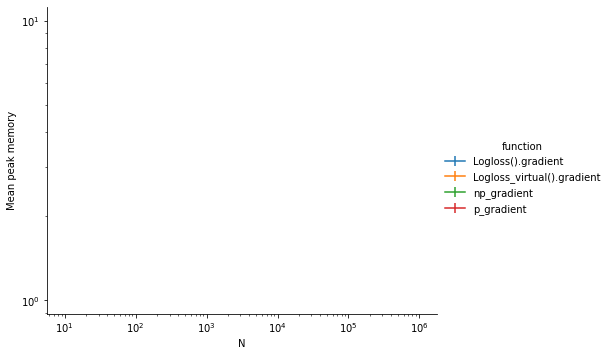

In [26]:
g = sns.FacetGrid(df.peak_memory.reset_index(), hue="function", height=5, aspect=4/3)
g.map_dataframe(errplot, "N", "mean", "std")
g.set(xscale="log", yscale="log")
g.set_axis_labels(y_var="Mean peak memory")
g.add_legend()